# From Pixels to Insights: Demystifying Vision Transformers for Image-based Machine Learning ; Hands-on section

## Corning - Merck symposium 2023

The following sections are covered in the notebook:

* Loading benchmark vision datasets
* Loading pre-trained Vision Transformer (ViT) models
* Fine-tuning a ViT model using new dataset
* Understanding the working of attention layers
* Understanding the inner components of a vision transformer model

- Original vision transformer paper: Alexey Dosovitskiy et al., "An Image Is Worth 16x16 Words: Transformers for Image Recognition at Scale",
https://arxiv.org/abs/2010.11929

Some of the cells in this notebook: https://colab.research.google.com/github/hirotomusiker/schwert_colab_data_storage/blob/master/notebook/Vision_Transformer_Tutorial.ipynb

### Install and load the required libraries

In [1]:
import torch                                # PyTorch library
import torchvision                          # Library from PyTorch project that contains popular vision datasets, 
                                            # vision models, and image transformations
from torch.utils.data import Subset         # Module needed to select a subset of dataset
from matplotlib import pyplot as plt        # Image and plot visualization
import numpy as np                          # Library to handle arrays and algebraic computations


try:
    import timm
    from timm import create_model           # PyTorch Image Models (TIMM) is a collection of pre-trained image models and 
except:                                     # methods required for training ML models
    !pip install timm
    import timm
    from timm import create_model  

* 2 different notebooks - pyT and Tf

* Training from scratch (pro: flexibility in terms of input image shapes) vs using pre-trained models (pro : requires fewer training data) 

### Setting up the training dataset

In [2]:
#---------Define the necessary image transformations--------#

transform1 = torchvision.transforms.ToTensor()                   # Method that transforms the image format to PyTorch tensor
transform2 = torchvision.transforms.Resize((224,224))            # Method that resizes a RGB image to (224,224,3) 
                                                                 # Why we need to do that transform

transform = torchvision.transforms.Compose([transform1, transform2])   # Compose the two transforms into one master transform.
#transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((224,224))])

#---------Download the CIFAR 10 dataset-------------------#
traindata_full = torchvision.datasets.CIFAR10('./cifar10_root/', download=True, train = True, transform = transform)

#---------Overview of the dataset--------------------------#
# Number of data
num_train_data = len(traindata_full)
print('Number of images in the CIFAR10 dataset:', num_train_data)

# Number of classes
num_classes = len(traindata_full.classes)
print('Number of classes in the CIFAR10 dataset:', num_classes)

#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Number of images in the CIFAR10 dataset: 50000
Number of classes in the CIFAR10 dataset: 10


In [3]:
#------Manually defining the class labels in the CIFAR100 dataset-------#

class_dict = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 
              6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

"""class_dict = {0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3: 'bear', 4: 'beaver', 
              5: 'bed', 6: 'bee', 7: 'beetle', 8: 'bicycle', 9: 'bottle', 
              10: 'bowl', 11: 'boy', 12: 'bridge', 13: 'bus', 14: 'butterfly', 
              15: 'camel', 16: 'can', 17: 'castle', 18: 'caterpillar', 19: 'cattle', 
              20: 'chair', 21: 'chimpanzee', 22: 'clock', 23: 'cloud', 24: 'cockroach', 
              25: 'couch', 26: 'cra', 27: 'crocodile', 28: 'cup', 29: 'dinosaur', 
              30: 'dolphin', 31: 'elephant', 32: 'flatfish', 33: 'forest', 34: 'fox', 
              35: 'girl', 36: 'hamster', 37: 'house', 38: 'kangaroo', 39: 'keyboard', 
              40: 'lamp', 41: 'lawn_mower', 42: 'leopard', 43: 'lion', 44: 'lizard', 
              45: 'lobster', 46: 'man', 47: 'maple_tree', 48: 'motorcycle', 49: 'mountain', 
              50: 'mouse', 51: 'mushroom', 52: 'oak_tree', 53: 'orange', 54: 'orchid', 
              55: 'otter', 56: 'palm_tree', 57: 'pear', 58: 'pickup_truck', 59: 'pine_tree', 
              60: 'plain', 61: 'plate', 62: 'poppy', 63: 'porcupine', 64: 'possum', 
              65: 'rabbit', 66: 'raccoon', 67: 'ray', 68: 'road', 69: 'rocket', 
              70: 'rose', 71: 'sea', 72: 'seal', 73: 'shark', 74: 'shrew', 
              75: 'skunk', 76: 'skyscraper', 77: 'snail', 78: 'snake', 79: 'spider', 
              80: 'squirrel', 81: 'streetcar', 82: 'sunflower', 83: 'sweet_pepper', 
              84: 'table', 85: 'tank', 86: 'telephone', 87: 'television', 88: 'tiger', 
              89: 'tractor', 90: 'train', 91: 'trout', 92: 'tulip', 93: 'turtle', 
              94: 'wardrobe', 95: 'whale', 96: 'willow_tree', 97: 'wolf', 98: 'woman', 99: 'worm'}"""

"class_dict = {0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3: 'bear', 4: 'beaver', \n              5: 'bed', 6: 'bee', 7: 'beetle', 8: 'bicycle', 9: 'bottle', \n              10: 'bowl', 11: 'boy', 12: 'bridge', 13: 'bus', 14: 'butterfly', \n              15: 'camel', 16: 'can', 17: 'castle', 18: 'caterpillar', 19: 'cattle', \n              20: 'chair', 21: 'chimpanzee', 22: 'clock', 23: 'cloud', 24: 'cockroach', \n              25: 'couch', 26: 'cra', 27: 'crocodile', 28: 'cup', 29: 'dinosaur', \n              30: 'dolphin', 31: 'elephant', 32: 'flatfish', 33: 'forest', 34: 'fox', \n              35: 'girl', 36: 'hamster', 37: 'house', 38: 'kangaroo', 39: 'keyboard', \n              40: 'lamp', 41: 'lawn_mower', 42: 'leopard', 43: 'lion', 44: 'lizard', \n              45: 'lobster', 46: 'man', 47: 'maple_tree', 48: 'motorcycle', 49: 'mountain', \n              50: 'mouse', 51: 'mushroom', 52: 'oak_tree', 53: 'orange', 54: 'orchid', \n              55: 'otter', 56: 'palm_tree', 57: 'pea

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0


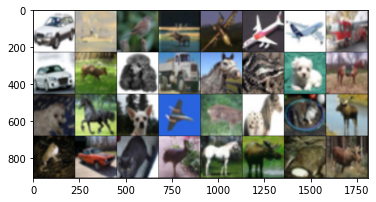

['car', 'ship', 'bird', 'deer', 'plane', 'plane', 'plane', 'truck', 'car', 'deer', 'dog', 'truck', 'horse', 'frog', 'dog', 'horse', 'dog', 'horse', 'dog', 'plane', 'deer', 'horse', 'cat', 'deer', 'frog', 'car', 'cat', 'bird', 'horse', 'deer', 'bird', 'deer']
1


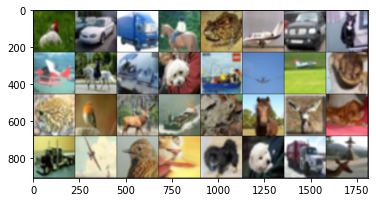

['bird', 'car', 'truck', 'horse', 'frog', 'plane', 'car', 'cat', 'plane', 'horse', 'ship', 'dog', 'ship', 'plane', 'plane', 'frog', 'frog', 'bird', 'deer', 'ship', 'frog', 'horse', 'deer', 'dog', 'truck', 'plane', 'bird', 'cat', 'dog', 'dog', 'truck', 'deer']
2


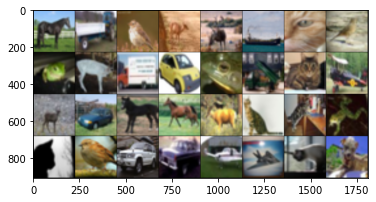

['horse', 'truck', 'bird', 'deer', 'deer', 'ship', 'cat', 'bird', 'frog', 'deer', 'truck', 'car', 'frog', 'truck', 'cat', 'plane', 'deer', 'car', 'horse', 'horse', 'deer', 'cat', 'cat', 'frog', 'cat', 'bird', 'car', 'car', 'plane', 'plane', 'cat', 'dog']


In [4]:
#---------------Setting up the dataloader for training----------------#

indices = list(range(50000))                                    
traindata = Subset(traindata_full, indices)                   # Selecting the first 100 images from the whole dataset
trainloader = torch.utils.data.DataLoader(traindata, batch_size=32,shuffle=True, num_workers=1)  #batch size = 4


#----------------Visualizing images in the dataset--------------#
def imshow(img):                                              # Function to visualize image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))                # Transforming images from (channels, height, width) to (h,w,c)
    plt.show()

dataiter = iter(trainloader)                                  # Iterable trainloader

for _ in range(3):                                            # Visualizing 3 batches of images (batch size = 4)
    print(_)
    images, labels = next(dataiter)                           # The 'next' attribute helps to move to the next batch
    imshow(torchvision.utils.make_grid(images))               # torchvision method that allows visualizing images in a grid
    print([class_dict[label.item()] for label in labels])

### Setting up the model

In [5]:
#---------------A sneak peek at the overall list of models in timm------------#

models = timm.list_models('*', pretrained = True)                             # Select all the models in timm
print("Random selection of 10 models from the overall list of models:\n")
print([models[i] for i in torch.randperm(len(models))[:10].tolist()])         # Select 10 random models from the list to display
print("\n")

vit_models = timm.list_models('vit*', pretrained = True)                      # Select all the vit models in timm
print("Random selection of 10 models from the overall list of vit models:\n")
print([vit_models[i] for i in torch.randperm(len(vit_models))[:10].tolist()]) # Select 10 random models from the list to display
print("\n")

Random selection of 10 models from the overall list of models:

['eva02_large_patch14_448.mim_in22k_ft_in22k_in1k', 'tf_efficientnet_b1.ns_jft_in1k', 'ecaresnet101d.miil_in1k', 'convnext_tiny.in12k_ft_in1k_384', 'gmixer_24_224.ra3_in1k', 'convnext_large_mlp.clip_laion2b_augreg_ft_in1k_384', 'convnextv2_huge.fcmae_ft_in1k', 'volo_d5_512.sail_in1k', 'vit_base_patch16_clip_384.laion2b_ft_in1k', 'hrnet_w40.ms_in1k']


Random selection of 10 models from the overall list of vit models:

['vit_small_patch16_224.augreg_in1k', 'vit_large_patch14_dinov2.lvd142m', 'vit_large_patch32_224.orig_in21k', 'vit_huge_patch14_clip_224.laion2b_ft_in12k_in1k', 'vit_large_patch16_224.mae', 'vit_base_patch16_clip_384.openai_ft_in1k', 'vit_base_patch16_384.orig_in21k_ft_in1k', 'vit_large_patch14_clip_336.laion2b_ft_in1k', 'vit_base_patch16_clip_384.openai_ft_in12k_in1k', 'vit_base_patch32_clip_224.laion2b_ft_in1k']




In [6]:
#timm.list_models('vit*', pretrained = True) 

In [7]:
#-------------------------Defining the model-----------------------------------#

model_name = 'vit_tiny_patch16_224.augreg_in21k'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
model = create_model(model_name, pretrained = True, num_classes = 10).to(device)

#model.load_state_dict(torch.load(f'vit_finetuning_model.pth'))

device =  cpu


### Training the model

In [8]:
loss_criterion = torch.nn.CrossEntropyLoss()                              # Cross-entropy loss is the loss criterion
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)   # SGD is the optimizer
num_epochs = 100                                                            # Number of training epochs

In [10]:
for epoch in range(num_epochs): 
    print(epoch)
    running_loss = 0.0
    correct, total = 0, 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data                                             # get the inputs; data is a list of [inputs, labels]
        optimizer.zero_grad()                                             # zero the parameter gradients for the fresh epoch

        outputs = model(inputs)                                           # Feed forward step
        loss = loss_criterion(outputs, labels)                            # Compute the loss 
        loss.backward()                                                   # Backward propagation
        optimizer.step()                                                  # Update model parameter weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 20 == 0:                                                   # print every 10 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}, accuracy: {correct / total:.3f}')
            running_loss = 0.0
    torch.save(model.state_dict(), f'vit_finetuning_model_tiny_16_224.pth')

print('Finished Training')

0


/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[1,     1] loss: 0.175, accuracy: 0.094
[1,    21] loss: 25.514, accuracy: 0.103
[1,    41] loss: 27.149, accuracy: 0.104
[1,    61] loss: 7.838, accuracy: 0.099
[1,    81] loss: 2.942, accuracy: 0.105
[1,   101] loss: 2.584, accuracy: 0.104
[1,   121] loss: 2.451, accuracy: 0.104
[1,   141] loss: 2.379, accuracy: 0.108
[1,   161] loss: 2.391, accuracy: 0.110
[1,   181] loss: 2.336, accuracy: 0.110
[1,   201] loss: 2.424, accuracy: 0.108
[1,   221] loss: 2.421, accuracy: 0.108
[1,   241] loss: 2.361, accuracy: 0.109
[1,   261] loss: 2.337, accuracy: 0.109
[1,   281] loss: 2.321, accuracy: 0.110
[1,   301] loss: 2.378, accuracy: 0.111
[1,   321] loss: 2.473, accuracy: 0.110
[1,   341] loss: 2.326, accuracy: 0.111
[1,   361] loss: 2.344, accuracy: 0.111
[1,   381] loss: 2.444, accuracy: 0.112
[1,   401] loss: 2.430, accuracy: 0.111
[1,   421] loss: 2.348, accuracy: 0.113
[1,   441] loss: 2.331, accuracy: 0.113
[1,   461] loss: 2.264, accuracy: 0.115
[1,   481] loss: 2.228, accuracy: 0.11

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[2,     1] loss: 0.089, accuracy: 0.312
[2,    21] loss: 1.827, accuracy: 0.298
[2,    41] loss: 1.809, accuracy: 0.294
[2,    61] loss: 1.762, accuracy: 0.305
[2,    81] loss: 1.821, accuracy: 0.309
[2,   101] loss: 1.778, accuracy: 0.314
[2,   121] loss: 1.861, accuracy: 0.309
[2,   141] loss: 1.860, accuracy: 0.305
[2,   161] loss: 1.830, accuracy: 0.304
[2,   181] loss: 1.826, accuracy: 0.306
[2,   201] loss: 1.789, accuracy: 0.307
[2,   221] loss: 1.799, accuracy: 0.308
[2,   241] loss: 1.785, accuracy: 0.310
[2,   261] loss: 1.865, accuracy: 0.308
[2,   281] loss: 1.778, accuracy: 0.310
[2,   301] loss: 1.746, accuracy: 0.313
[2,   321] loss: 1.724, accuracy: 0.317
[2,   341] loss: 1.741, accuracy: 0.318
[2,   361] loss: 1.772, accuracy: 0.318
[2,   381] loss: 1.720, accuracy: 0.319
[2,   401] loss: 1.709, accuracy: 0.321
[2,   421] loss: 1.741, accuracy: 0.321
[2,   441] loss: 1.836, accuracy: 0.322
[2,   461] loss: 1.730, accuracy: 0.325
[2,   481] loss: 1.744, accuracy: 0.325


/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[3,     1] loss: 0.076, accuracy: 0.344
[3,    21] loss: 1.284, accuracy: 0.530
[3,    41] loss: 1.308, accuracy: 0.519
[3,    61] loss: 1.303, accuracy: 0.518
[3,    81] loss: 1.326, accuracy: 0.516
[3,   101] loss: 1.342, accuracy: 0.520
[3,   121] loss: 1.188, accuracy: 0.534
[3,   141] loss: 1.284, accuracy: 0.533
[3,   161] loss: 1.380, accuracy: 0.526
[3,   181] loss: 1.361, accuracy: 0.524
[3,   201] loss: 1.325, accuracy: 0.525
[3,   221] loss: 1.333, accuracy: 0.522
[3,   241] loss: 1.311, accuracy: 0.523
[3,   261] loss: 1.291, accuracy: 0.522
[3,   281] loss: 1.251, accuracy: 0.524
[3,   301] loss: 1.460, accuracy: 0.523
[3,   321] loss: 1.286, accuracy: 0.524
[3,   341] loss: 1.256, accuracy: 0.524
[3,   361] loss: 1.298, accuracy: 0.524
[3,   381] loss: 1.238, accuracy: 0.525
[3,   401] loss: 1.305, accuracy: 0.524
[3,   421] loss: 1.151, accuracy: 0.528
[3,   441] loss: 1.176, accuracy: 0.530
[3,   461] loss: 1.213, accuracy: 0.531
[3,   481] loss: 1.222, accuracy: 0.533


/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[4,     1] loss: 0.044, accuracy: 0.594
[4,    21] loss: 1.036, accuracy: 0.629
[4,    41] loss: 0.985, accuracy: 0.644
[4,    61] loss: 0.991, accuracy: 0.645
[4,    81] loss: 0.908, accuracy: 0.654
[4,   101] loss: 1.097, accuracy: 0.645
[4,   121] loss: 1.047, accuracy: 0.644
[4,   141] loss: 0.988, accuracy: 0.645
[4,   161] loss: 0.896, accuracy: 0.649
[4,   181] loss: 0.918, accuracy: 0.651
[4,   201] loss: 0.969, accuracy: 0.652
[4,   221] loss: 0.994, accuracy: 0.652
[4,   241] loss: 0.924, accuracy: 0.653
[4,   261] loss: 1.088, accuracy: 0.651
[4,   281] loss: 0.954, accuracy: 0.652
[4,   301] loss: 0.979, accuracy: 0.651
[4,   321] loss: 0.984, accuracy: 0.651
[4,   341] loss: 0.900, accuracy: 0.651
[4,   361] loss: 0.988, accuracy: 0.651
[4,   381] loss: 0.926, accuracy: 0.652
[4,   401] loss: 0.950, accuracy: 0.653
[4,   421] loss: 1.037, accuracy: 0.653
[4,   441] loss: 0.883, accuracy: 0.654
[4,   461] loss: 0.985, accuracy: 0.654
[4,   481] loss: 0.982, accuracy: 0.653


/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[5,     1] loss: 0.040, accuracy: 0.688
[5,    21] loss: 0.730, accuracy: 0.735
[5,    41] loss: 0.718, accuracy: 0.740
[5,    61] loss: 0.839, accuracy: 0.726
[5,    81] loss: 0.820, accuracy: 0.723
[5,   101] loss: 0.824, accuracy: 0.722
[5,   121] loss: 0.721, accuracy: 0.724
[5,   141] loss: 0.779, accuracy: 0.724
[5,   161] loss: 0.789, accuracy: 0.724
[5,   181] loss: 0.766, accuracy: 0.725
[5,   201] loss: 0.841, accuracy: 0.723
[5,   221] loss: 0.796, accuracy: 0.724
[5,   241] loss: 0.823, accuracy: 0.721
[5,   261] loss: 0.828, accuracy: 0.720
[5,   281] loss: 0.773, accuracy: 0.722
[5,   301] loss: 0.862, accuracy: 0.719
[5,   321] loss: 0.716, accuracy: 0.720
[5,   341] loss: 0.721, accuracy: 0.722
[5,   361] loss: 0.677, accuracy: 0.723
[5,   381] loss: 0.754, accuracy: 0.724
[5,   401] loss: 0.758, accuracy: 0.724
[5,   421] loss: 0.764, accuracy: 0.725
[5,   441] loss: 0.720, accuracy: 0.725
[5,   461] loss: 0.725, accuracy: 0.726
[5,   481] loss: 0.751, accuracy: 0.727


/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[6,     1] loss: 0.045, accuracy: 0.688
[6,    21] loss: 0.654, accuracy: 0.759
[6,    41] loss: 0.608, accuracy: 0.768
[6,    61] loss: 0.599, accuracy: 0.774
[6,    81] loss: 0.668, accuracy: 0.767
[6,   101] loss: 0.690, accuracy: 0.761
[6,   121] loss: 0.665, accuracy: 0.765
[6,   141] loss: 0.680, accuracy: 0.765
[6,   161] loss: 0.754, accuracy: 0.762
[6,   181] loss: 0.751, accuracy: 0.759
[6,   201] loss: 0.702, accuracy: 0.759
[6,   221] loss: 0.693, accuracy: 0.758
[6,   241] loss: 0.651, accuracy: 0.758
[6,   261] loss: 0.655, accuracy: 0.759
[6,   281] loss: 0.612, accuracy: 0.761
[6,   301] loss: 0.627, accuracy: 0.762
[6,   321] loss: 0.698, accuracy: 0.761
[6,   341] loss: 0.654, accuracy: 0.761
[6,   361] loss: 0.639, accuracy: 0.763
[6,   381] loss: 0.728, accuracy: 0.761
[6,   401] loss: 0.584, accuracy: 0.763
[6,   421] loss: 0.647, accuracy: 0.764
[6,   441] loss: 0.693, accuracy: 0.762
[6,   461] loss: 0.601, accuracy: 0.764
[6,   481] loss: 0.658, accuracy: 0.763


/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[7,     1] loss: 0.023, accuracy: 0.844
[7,    21] loss: 0.542, accuracy: 0.811
[7,    41] loss: 0.492, accuracy: 0.815
[7,    61] loss: 0.494, accuracy: 0.822
[7,    81] loss: 0.543, accuracy: 0.817
[7,   101] loss: 0.548, accuracy: 0.814
[7,   121] loss: 0.666, accuracy: 0.807
[7,   141] loss: 0.522, accuracy: 0.806
[7,   161] loss: 0.547, accuracy: 0.806
[7,   181] loss: 0.537, accuracy: 0.806
[7,   201] loss: 0.585, accuracy: 0.804
[7,   221] loss: 0.630, accuracy: 0.801
[7,   241] loss: 0.643, accuracy: 0.800
[7,   261] loss: 0.619, accuracy: 0.800
[7,   281] loss: 0.577, accuracy: 0.798
[7,   301] loss: 0.523, accuracy: 0.799
[7,   321] loss: 0.568, accuracy: 0.800
[7,   341] loss: 0.596, accuracy: 0.798
[7,   361] loss: 0.627, accuracy: 0.797
[7,   381] loss: 0.597, accuracy: 0.797
[7,   401] loss: 0.639, accuracy: 0.795
[7,   421] loss: 0.528, accuracy: 0.796
[7,   441] loss: 0.514, accuracy: 0.797
[7,   461] loss: 0.531, accuracy: 0.798
[7,   481] loss: 0.584, accuracy: 0.798


/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[8,     1] loss: 0.042, accuracy: 0.688
[8,    21] loss: 0.464, accuracy: 0.838
[8,    41] loss: 0.414, accuracy: 0.851
[8,    61] loss: 0.449, accuracy: 0.847
[8,    81] loss: 0.454, accuracy: 0.843
[8,   101] loss: 0.465, accuracy: 0.845
[8,   121] loss: 0.583, accuracy: 0.838
[8,   141] loss: 0.464, accuracy: 0.838
[8,   161] loss: 0.511, accuracy: 0.838
[8,   181] loss: 0.434, accuracy: 0.838
[8,   201] loss: 0.463, accuracy: 0.837
[8,   221] loss: 0.476, accuracy: 0.836
[8,   241] loss: 0.581, accuracy: 0.834
[8,   261] loss: 0.466, accuracy: 0.835
[8,   281] loss: 0.533, accuracy: 0.834
[8,   301] loss: 0.545, accuracy: 0.831
[8,   321] loss: 0.466, accuracy: 0.832
[8,   341] loss: 0.492, accuracy: 0.831
[8,   361] loss: 0.534, accuracy: 0.830
[8,   381] loss: 0.492, accuracy: 0.829
[8,   401] loss: 0.588, accuracy: 0.828
[8,   421] loss: 0.548, accuracy: 0.827
[8,   441] loss: 0.526, accuracy: 0.826
[8,   461] loss: 0.551, accuracy: 0.825
[8,   481] loss: 0.527, accuracy: 0.824


/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[9,     1] loss: 0.017, accuracy: 0.875
[9,    21] loss: 0.422, accuracy: 0.839
[9,    41] loss: 0.425, accuracy: 0.845
[9,    61] loss: 0.402, accuracy: 0.845
[9,    81] loss: 0.474, accuracy: 0.845
[9,   101] loss: 0.461, accuracy: 0.845
[9,   121] loss: 0.420, accuracy: 0.846
[9,   141] loss: 0.416, accuracy: 0.847
[9,   161] loss: 0.411, accuracy: 0.847
[9,   181] loss: 0.460, accuracy: 0.846
[9,   201] loss: 0.463, accuracy: 0.847
[9,   221] loss: 0.436, accuracy: 0.848
[9,   241] loss: 0.395, accuracy: 0.850
[9,   261] loss: 0.410, accuracy: 0.851
[9,   281] loss: 0.421, accuracy: 0.851
[9,   301] loss: 0.467, accuracy: 0.851
[9,   321] loss: 0.486, accuracy: 0.850
[9,   341] loss: 0.437, accuracy: 0.850
[9,   361] loss: 0.461, accuracy: 0.850
[9,   381] loss: 0.419, accuracy: 0.850
[9,   401] loss: 0.533, accuracy: 0.848
[9,   421] loss: 0.426, accuracy: 0.848
[9,   441] loss: 0.496, accuracy: 0.847
[9,   461] loss: 0.488, accuracy: 0.846
[9,   481] loss: 0.485, accuracy: 0.845


/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[10,     1] loss: 0.020, accuracy: 0.875
[10,    21] loss: 0.356, accuracy: 0.868
[10,    41] loss: 0.362, accuracy: 0.867
[10,    61] loss: 0.364, accuracy: 0.864
[10,    81] loss: 0.317, accuracy: 0.868
[10,   101] loss: 0.437, accuracy: 0.862
[10,   121] loss: 0.371, accuracy: 0.863
[10,   141] loss: 0.401, accuracy: 0.864
[10,   161] loss: 0.356, accuracy: 0.864
[10,   181] loss: 0.388, accuracy: 0.863
[10,   201] loss: 0.424, accuracy: 0.861
[10,   221] loss: 0.464, accuracy: 0.858
[10,   241] loss: 0.330, accuracy: 0.860
[10,   261] loss: 0.383, accuracy: 0.859
[10,   281] loss: 0.395, accuracy: 0.859
[10,   301] loss: 0.468, accuracy: 0.858
[10,   321] loss: 0.406, accuracy: 0.859
[10,   341] loss: 0.382, accuracy: 0.859
[10,   361] loss: 0.427, accuracy: 0.858
[10,   381] loss: 0.380, accuracy: 0.859
[10,   401] loss: 0.362, accuracy: 0.859
[10,   421] loss: 0.401, accuracy: 0.858
[10,   441] loss: 0.422, accuracy: 0.858
[10,   461] loss: 0.341, accuracy: 0.859
[10,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[11,     1] loss: 0.021, accuracy: 0.875
[11,    21] loss: 0.307, accuracy: 0.900
[11,    41] loss: 0.432, accuracy: 0.878
[11,    61] loss: 0.344, accuracy: 0.877
[11,    81] loss: 0.347, accuracy: 0.878
[11,   101] loss: 0.359, accuracy: 0.878
[11,   121] loss: 0.341, accuracy: 0.879
[11,   141] loss: 0.369, accuracy: 0.877
[11,   161] loss: 0.364, accuracy: 0.876
[11,   181] loss: 0.398, accuracy: 0.874
[11,   201] loss: 0.343, accuracy: 0.875
[11,   221] loss: 0.355, accuracy: 0.875
[11,   241] loss: 0.338, accuracy: 0.876
[11,   261] loss: 0.379, accuracy: 0.875
[11,   281] loss: 0.432, accuracy: 0.871
[11,   301] loss: 0.341, accuracy: 0.871
[11,   321] loss: 0.391, accuracy: 0.870
[11,   341] loss: 0.337, accuracy: 0.871
[11,   361] loss: 0.341, accuracy: 0.871
[11,   381] loss: 0.368, accuracy: 0.871
[11,   401] loss: 0.309, accuracy: 0.872
[11,   421] loss: 0.375, accuracy: 0.872
[11,   441] loss: 0.333, accuracy: 0.872
[11,   461] loss: 0.353, accuracy: 0.872
[11,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[12,     1] loss: 0.025, accuracy: 0.844
[12,    21] loss: 0.318, accuracy: 0.876
[12,    41] loss: 0.289, accuracy: 0.883
[12,    61] loss: 0.303, accuracy: 0.888
[12,    81] loss: 0.283, accuracy: 0.890
[12,   101] loss: 0.324, accuracy: 0.890
[12,   121] loss: 0.340, accuracy: 0.885
[12,   141] loss: 0.398, accuracy: 0.880
[12,   161] loss: 0.319, accuracy: 0.881
[12,   181] loss: 0.324, accuracy: 0.882
[12,   201] loss: 0.362, accuracy: 0.880
[12,   221] loss: 0.359, accuracy: 0.879
[12,   241] loss: 0.307, accuracy: 0.879
[12,   261] loss: 0.333, accuracy: 0.878
[12,   281] loss: 0.374, accuracy: 0.878
[12,   301] loss: 0.353, accuracy: 0.878
[12,   321] loss: 0.276, accuracy: 0.880
[12,   341] loss: 0.344, accuracy: 0.880
[12,   361] loss: 0.258, accuracy: 0.881
[12,   381] loss: 0.322, accuracy: 0.882
[12,   401] loss: 0.350, accuracy: 0.882
[12,   421] loss: 0.301, accuracy: 0.882
[12,   441] loss: 0.256, accuracy: 0.883
[12,   461] loss: 0.326, accuracy: 0.883
[12,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[13,     1] loss: 0.013, accuracy: 0.969
[13,    21] loss: 0.236, accuracy: 0.920
[13,    41] loss: 0.306, accuracy: 0.903
[13,    61] loss: 0.308, accuracy: 0.899
[13,    81] loss: 0.231, accuracy: 0.901
[13,   101] loss: 0.223, accuracy: 0.903
[13,   121] loss: 0.279, accuracy: 0.904
[13,   141] loss: 0.223, accuracy: 0.908
[13,   161] loss: 0.268, accuracy: 0.907
[13,   181] loss: 0.250, accuracy: 0.907
[13,   201] loss: 0.272, accuracy: 0.907
[13,   221] loss: 0.318, accuracy: 0.905
[13,   241] loss: 0.303, accuracy: 0.904
[13,   261] loss: 0.298, accuracy: 0.904
[13,   281] loss: 0.291, accuracy: 0.903
[13,   301] loss: 0.293, accuracy: 0.902
[13,   321] loss: 0.257, accuracy: 0.903
[13,   341] loss: 0.337, accuracy: 0.902
[13,   361] loss: 0.327, accuracy: 0.900
[13,   381] loss: 0.267, accuracy: 0.900
[13,   401] loss: 0.274, accuracy: 0.900
[13,   421] loss: 0.300, accuracy: 0.900
[13,   441] loss: 0.253, accuracy: 0.900
[13,   461] loss: 0.332, accuracy: 0.900
[13,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[14,     1] loss: 0.006, accuracy: 0.969
[14,    21] loss: 0.263, accuracy: 0.903
[14,    41] loss: 0.218, accuracy: 0.913
[14,    61] loss: 0.216, accuracy: 0.921
[14,    81] loss: 0.250, accuracy: 0.916
[14,   101] loss: 0.202, accuracy: 0.918
[14,   121] loss: 0.227, accuracy: 0.918
[14,   141] loss: 0.200, accuracy: 0.919
[14,   161] loss: 0.272, accuracy: 0.919
[14,   181] loss: 0.308, accuracy: 0.916
[14,   201] loss: 0.318, accuracy: 0.912
[14,   221] loss: 0.283, accuracy: 0.912
[14,   241] loss: 0.277, accuracy: 0.910
[14,   261] loss: 0.262, accuracy: 0.910
[14,   281] loss: 0.281, accuracy: 0.909
[14,   301] loss: 0.254, accuracy: 0.909
[14,   321] loss: 0.185, accuracy: 0.910
[14,   341] loss: 0.312, accuracy: 0.908
[14,   361] loss: 0.323, accuracy: 0.907
[14,   381] loss: 0.297, accuracy: 0.906
[14,   401] loss: 0.230, accuracy: 0.906
[14,   421] loss: 0.336, accuracy: 0.905
[14,   441] loss: 0.237, accuracy: 0.905
[14,   461] loss: 0.234, accuracy: 0.906
[14,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[15,     1] loss: 0.009, accuracy: 0.906
[15,    21] loss: 0.220, accuracy: 0.917
[15,    41] loss: 0.219, accuracy: 0.922
[15,    61] loss: 0.226, accuracy: 0.922
[15,    81] loss: 0.227, accuracy: 0.919
[15,   101] loss: 0.277, accuracy: 0.918
[15,   121] loss: 0.239, accuracy: 0.918
[15,   141] loss: 0.219, accuracy: 0.921
[15,   161] loss: 0.250, accuracy: 0.920
[15,   181] loss: 0.206, accuracy: 0.919
[15,   201] loss: 0.179, accuracy: 0.920
[15,   221] loss: 0.230, accuracy: 0.920
[15,   241] loss: 0.277, accuracy: 0.918
[15,   261] loss: 0.209, accuracy: 0.918
[15,   281] loss: 0.270, accuracy: 0.917
[15,   301] loss: 0.197, accuracy: 0.918
[15,   321] loss: 0.239, accuracy: 0.919
[15,   341] loss: 0.312, accuracy: 0.918
[15,   361] loss: 0.299, accuracy: 0.916
[15,   381] loss: 0.208, accuracy: 0.917
[15,   401] loss: 0.239, accuracy: 0.916
[15,   421] loss: 0.229, accuracy: 0.916
[15,   441] loss: 0.274, accuracy: 0.916
[15,   461] loss: 0.264, accuracy: 0.915
[15,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[16,     1] loss: 0.001, accuracy: 1.000
[16,    21] loss: 0.202, accuracy: 0.938
[16,    41] loss: 0.196, accuracy: 0.938
[16,    61] loss: 0.164, accuracy: 0.942
[16,    81] loss: 0.179, accuracy: 0.940
[16,   101] loss: 0.199, accuracy: 0.936
[16,   121] loss: 0.216, accuracy: 0.935
[16,   141] loss: 0.204, accuracy: 0.934
[16,   161] loss: 0.195, accuracy: 0.934
[16,   181] loss: 0.187, accuracy: 0.934
[16,   201] loss: 0.157, accuracy: 0.935
[16,   221] loss: 0.251, accuracy: 0.932
[16,   241] loss: 0.202, accuracy: 0.933
[16,   261] loss: 0.233, accuracy: 0.931
[16,   281] loss: 0.218, accuracy: 0.930
[16,   301] loss: 0.183, accuracy: 0.931
[16,   321] loss: 0.313, accuracy: 0.929
[16,   341] loss: 0.223, accuracy: 0.928
[16,   361] loss: 0.243, accuracy: 0.928
[16,   381] loss: 0.184, accuracy: 0.928
[16,   401] loss: 0.184, accuracy: 0.928
[16,   421] loss: 0.211, accuracy: 0.927
[16,   441] loss: 0.212, accuracy: 0.927
[16,   461] loss: 0.209, accuracy: 0.927
[16,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[17,     1] loss: 0.006, accuracy: 0.938
[17,    21] loss: 0.147, accuracy: 0.946
[17,    41] loss: 0.158, accuracy: 0.947
[17,    61] loss: 0.176, accuracy: 0.943
[17,    81] loss: 0.205, accuracy: 0.937
[17,   101] loss: 0.149, accuracy: 0.940
[17,   121] loss: 0.163, accuracy: 0.940
[17,   141] loss: 0.211, accuracy: 0.937
[17,   161] loss: 0.251, accuracy: 0.933
[17,   181] loss: 0.263, accuracy: 0.931
[17,   201] loss: 0.172, accuracy: 0.931
[17,   221] loss: 0.215, accuracy: 0.930
[17,   241] loss: 0.251, accuracy: 0.929
[17,   261] loss: 0.219, accuracy: 0.929
[17,   281] loss: 0.211, accuracy: 0.929
[17,   301] loss: 0.193, accuracy: 0.929
[17,   321] loss: 0.248, accuracy: 0.928
[17,   341] loss: 0.142, accuracy: 0.930
[17,   361] loss: 0.154, accuracy: 0.931
[17,   381] loss: 0.181, accuracy: 0.931
[17,   401] loss: 0.193, accuracy: 0.931
[17,   421] loss: 0.183, accuracy: 0.931
[17,   441] loss: 0.196, accuracy: 0.931
[17,   461] loss: 0.251, accuracy: 0.930
[17,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[18,     1] loss: 0.006, accuracy: 0.969
[18,    21] loss: 0.155, accuracy: 0.951
[18,    41] loss: 0.151, accuracy: 0.948
[18,    61] loss: 0.114, accuracy: 0.951
[18,    81] loss: 0.106, accuracy: 0.954
[18,   101] loss: 0.165, accuracy: 0.953
[18,   121] loss: 0.194, accuracy: 0.948
[18,   141] loss: 0.143, accuracy: 0.948
[18,   161] loss: 0.168, accuracy: 0.946
[18,   181] loss: 0.151, accuracy: 0.946
[18,   201] loss: 0.150, accuracy: 0.947
[18,   221] loss: 0.190, accuracy: 0.946
[18,   241] loss: 0.187, accuracy: 0.945
[18,   261] loss: 0.133, accuracy: 0.945
[18,   281] loss: 0.165, accuracy: 0.945
[18,   301] loss: 0.134, accuracy: 0.946
[18,   321] loss: 0.174, accuracy: 0.945
[18,   341] loss: 0.222, accuracy: 0.943
[18,   361] loss: 0.140, accuracy: 0.944
[18,   381] loss: 0.206, accuracy: 0.942
[18,   401] loss: 0.175, accuracy: 0.942
[18,   421] loss: 0.144, accuracy: 0.942
[18,   441] loss: 0.174, accuracy: 0.942
[18,   461] loss: 0.175, accuracy: 0.941
[18,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[19,     1] loss: 0.007, accuracy: 0.969
[19,    21] loss: 0.154, accuracy: 0.943
[19,    41] loss: 0.145, accuracy: 0.945
[19,    61] loss: 0.150, accuracy: 0.946
[19,    81] loss: 0.134, accuracy: 0.948
[19,   101] loss: 0.161, accuracy: 0.946
[19,   121] loss: 0.159, accuracy: 0.944
[19,   141] loss: 0.122, accuracy: 0.947
[19,   161] loss: 0.105, accuracy: 0.951
[19,   181] loss: 0.124, accuracy: 0.951
[19,   201] loss: 0.191, accuracy: 0.949
[19,   221] loss: 0.175, accuracy: 0.948
[19,   241] loss: 0.159, accuracy: 0.948
[19,   261] loss: 0.162, accuracy: 0.947
[19,   281] loss: 0.142, accuracy: 0.947
[19,   301] loss: 0.157, accuracy: 0.946
[19,   321] loss: 0.125, accuracy: 0.947
[19,   341] loss: 0.172, accuracy: 0.947
[19,   361] loss: 0.168, accuracy: 0.946
[19,   381] loss: 0.196, accuracy: 0.945
[19,   401] loss: 0.179, accuracy: 0.945
[19,   421] loss: 0.155, accuracy: 0.945
[19,   441] loss: 0.155, accuracy: 0.946
[19,   461] loss: 0.138, accuracy: 0.946
[19,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[20,     1] loss: 0.007, accuracy: 0.906
[20,    21] loss: 0.141, accuracy: 0.943
[20,    41] loss: 0.146, accuracy: 0.942
[20,    61] loss: 0.145, accuracy: 0.946
[20,    81] loss: 0.166, accuracy: 0.944
[20,   101] loss: 0.113, accuracy: 0.947
[20,   121] loss: 0.168, accuracy: 0.946
[20,   141] loss: 0.086, accuracy: 0.950
[20,   161] loss: 0.114, accuracy: 0.951
[20,   181] loss: 0.089, accuracy: 0.953
[20,   201] loss: 0.103, accuracy: 0.954
[20,   221] loss: 0.100, accuracy: 0.956
[20,   241] loss: 0.130, accuracy: 0.956
[20,   261] loss: 0.117, accuracy: 0.956
[20,   281] loss: 0.191, accuracy: 0.954
[20,   301] loss: 0.143, accuracy: 0.954
[20,   321] loss: 0.157, accuracy: 0.953
[20,   341] loss: 0.122, accuracy: 0.954
[20,   361] loss: 0.178, accuracy: 0.953
[20,   381] loss: 0.196, accuracy: 0.952
[20,   401] loss: 0.199, accuracy: 0.951
[20,   421] loss: 0.162, accuracy: 0.950
[20,   441] loss: 0.159, accuracy: 0.950
[20,   461] loss: 0.116, accuracy: 0.951
[20,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[21,     1] loss: 0.009, accuracy: 0.938
[21,    21] loss: 0.120, accuracy: 0.957
[21,    41] loss: 0.107, accuracy: 0.954
[21,    61] loss: 0.101, accuracy: 0.957
[21,    81] loss: 0.117, accuracy: 0.958
[21,   101] loss: 0.105, accuracy: 0.958
[21,   121] loss: 0.114, accuracy: 0.957
[21,   141] loss: 0.148, accuracy: 0.956
[21,   161] loss: 0.132, accuracy: 0.956
[21,   181] loss: 0.127, accuracy: 0.956
[21,   201] loss: 0.126, accuracy: 0.956
[21,   221] loss: 0.130, accuracy: 0.957
[21,   241] loss: 0.158, accuracy: 0.955
[21,   261] loss: 0.118, accuracy: 0.955
[21,   281] loss: 0.119, accuracy: 0.956
[21,   301] loss: 0.083, accuracy: 0.956
[21,   321] loss: 0.112, accuracy: 0.956
[21,   341] loss: 0.156, accuracy: 0.956
[21,   361] loss: 0.203, accuracy: 0.954
[21,   381] loss: 0.141, accuracy: 0.954
[21,   401] loss: 0.203, accuracy: 0.953
[21,   421] loss: 0.153, accuracy: 0.952
[21,   441] loss: 0.152, accuracy: 0.952
[21,   461] loss: 0.144, accuracy: 0.951
[21,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[22,     1] loss: 0.004, accuracy: 1.000
[22,    21] loss: 0.096, accuracy: 0.966
[22,    41] loss: 0.095, accuracy: 0.966
[22,    61] loss: 0.091, accuracy: 0.967
[22,    81] loss: 0.089, accuracy: 0.968
[22,   101] loss: 0.109, accuracy: 0.966
[22,   121] loss: 0.110, accuracy: 0.964
[22,   141] loss: 0.101, accuracy: 0.964
[22,   161] loss: 0.110, accuracy: 0.964
[22,   181] loss: 0.126, accuracy: 0.963
[22,   201] loss: 0.126, accuracy: 0.962
[22,   221] loss: 0.098, accuracy: 0.962
[22,   241] loss: 0.103, accuracy: 0.962
[22,   261] loss: 0.121, accuracy: 0.961
[22,   281] loss: 0.156, accuracy: 0.960
[22,   301] loss: 0.111, accuracy: 0.961
[22,   321] loss: 0.112, accuracy: 0.960
[22,   341] loss: 0.102, accuracy: 0.961
[22,   361] loss: 0.153, accuracy: 0.960
[22,   381] loss: 0.114, accuracy: 0.960
[22,   401] loss: 0.118, accuracy: 0.960
[22,   421] loss: 0.143, accuracy: 0.959
[22,   441] loss: 0.142, accuracy: 0.959
[22,   461] loss: 0.139, accuracy: 0.959
[22,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[23,     1] loss: 0.005, accuracy: 0.938
[23,    21] loss: 0.128, accuracy: 0.958
[23,    41] loss: 0.086, accuracy: 0.963
[23,    61] loss: 0.112, accuracy: 0.960
[23,    81] loss: 0.082, accuracy: 0.963
[23,   101] loss: 0.077, accuracy: 0.965
[23,   121] loss: 0.118, accuracy: 0.964
[23,   141] loss: 0.118, accuracy: 0.963
[23,   161] loss: 0.111, accuracy: 0.962
[23,   181] loss: 0.136, accuracy: 0.962
[23,   201] loss: 0.088, accuracy: 0.963
[23,   221] loss: 0.082, accuracy: 0.964
[23,   241] loss: 0.144, accuracy: 0.963
[23,   261] loss: 0.144, accuracy: 0.962
[23,   281] loss: 0.110, accuracy: 0.962
[23,   301] loss: 0.122, accuracy: 0.962
[23,   321] loss: 0.126, accuracy: 0.962
[23,   341] loss: 0.085, accuracy: 0.963
[23,   361] loss: 0.103, accuracy: 0.962
[23,   381] loss: 0.147, accuracy: 0.961
[23,   401] loss: 0.140, accuracy: 0.960
[23,   421] loss: 0.169, accuracy: 0.959
[23,   441] loss: 0.135, accuracy: 0.958
[23,   461] loss: 0.100, accuracy: 0.958
[23,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[24,     1] loss: 0.005, accuracy: 0.938
[24,    21] loss: 0.083, accuracy: 0.981
[24,    41] loss: 0.080, accuracy: 0.974
[24,    61] loss: 0.105, accuracy: 0.969
[24,    81] loss: 0.088, accuracy: 0.969
[24,   101] loss: 0.095, accuracy: 0.968
[24,   121] loss: 0.083, accuracy: 0.968
[24,   141] loss: 0.132, accuracy: 0.967
[24,   161] loss: 0.088, accuracy: 0.966
[24,   181] loss: 0.108, accuracy: 0.966
[24,   201] loss: 0.079, accuracy: 0.966
[24,   221] loss: 0.133, accuracy: 0.965
[24,   241] loss: 0.111, accuracy: 0.965
[24,   261] loss: 0.080, accuracy: 0.965
[24,   281] loss: 0.090, accuracy: 0.965
[24,   301] loss: 0.097, accuracy: 0.965
[24,   321] loss: 0.112, accuracy: 0.965
[24,   341] loss: 0.092, accuracy: 0.965
[24,   361] loss: 0.132, accuracy: 0.965
[24,   381] loss: 0.171, accuracy: 0.964
[24,   401] loss: 0.164, accuracy: 0.963
[24,   421] loss: 0.123, accuracy: 0.962
[24,   441] loss: 0.112, accuracy: 0.962
[24,   461] loss: 0.123, accuracy: 0.962
[24,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[25,     1] loss: 0.002, accuracy: 1.000
[25,    21] loss: 0.069, accuracy: 0.979
[25,    41] loss: 0.095, accuracy: 0.973
[25,    61] loss: 0.071, accuracy: 0.974
[25,    81] loss: 0.086, accuracy: 0.975
[25,   101] loss: 0.099, accuracy: 0.972
[25,   121] loss: 0.104, accuracy: 0.970
[25,   141] loss: 0.139, accuracy: 0.966
[25,   161] loss: 0.107, accuracy: 0.966
[25,   181] loss: 0.114, accuracy: 0.965
[25,   201] loss: 0.124, accuracy: 0.964
[25,   221] loss: 0.133, accuracy: 0.964
[25,   241] loss: 0.092, accuracy: 0.964
[25,   261] loss: 0.133, accuracy: 0.963
[25,   281] loss: 0.074, accuracy: 0.964
[25,   301] loss: 0.098, accuracy: 0.964
[25,   321] loss: 0.076, accuracy: 0.964
[25,   341] loss: 0.073, accuracy: 0.965
[25,   361] loss: 0.083, accuracy: 0.965
[25,   381] loss: 0.107, accuracy: 0.965
[25,   401] loss: 0.088, accuracy: 0.965
[25,   421] loss: 0.116, accuracy: 0.965
[25,   441] loss: 0.072, accuracy: 0.965
[25,   461] loss: 0.100, accuracy: 0.965
[25,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[26,     1] loss: 0.002, accuracy: 1.000
[26,    21] loss: 0.092, accuracy: 0.978
[26,    41] loss: 0.071, accuracy: 0.976
[26,    61] loss: 0.077, accuracy: 0.974
[26,    81] loss: 0.047, accuracy: 0.977
[26,   101] loss: 0.072, accuracy: 0.976
[26,   121] loss: 0.069, accuracy: 0.976
[26,   141] loss: 0.084, accuracy: 0.975
[26,   161] loss: 0.088, accuracy: 0.974
[26,   181] loss: 0.052, accuracy: 0.975
[26,   201] loss: 0.072, accuracy: 0.976
[26,   221] loss: 0.044, accuracy: 0.976
[26,   241] loss: 0.079, accuracy: 0.976
[26,   261] loss: 0.087, accuracy: 0.976
[26,   281] loss: 0.112, accuracy: 0.974
[26,   301] loss: 0.080, accuracy: 0.974
[26,   321] loss: 0.081, accuracy: 0.974
[26,   341] loss: 0.059, accuracy: 0.974
[26,   361] loss: 0.064, accuracy: 0.974
[26,   381] loss: 0.105, accuracy: 0.973
[26,   401] loss: 0.153, accuracy: 0.972
[26,   421] loss: 0.103, accuracy: 0.971
[26,   441] loss: 0.106, accuracy: 0.971
[26,   461] loss: 0.109, accuracy: 0.971
[26,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[27,     1] loss: 0.002, accuracy: 1.000
[27,    21] loss: 0.092, accuracy: 0.961
[27,    41] loss: 0.077, accuracy: 0.966
[27,    61] loss: 0.068, accuracy: 0.970
[27,    81] loss: 0.048, accuracy: 0.974
[27,   101] loss: 0.053, accuracy: 0.975
[27,   121] loss: 0.093, accuracy: 0.973
[27,   141] loss: 0.071, accuracy: 0.973
[27,   161] loss: 0.058, accuracy: 0.974
[27,   181] loss: 0.089, accuracy: 0.973
[27,   201] loss: 0.125, accuracy: 0.972
[27,   221] loss: 0.074, accuracy: 0.973
[27,   241] loss: 0.050, accuracy: 0.974
[27,   261] loss: 0.056, accuracy: 0.974
[27,   281] loss: 0.053, accuracy: 0.974
[27,   301] loss: 0.104, accuracy: 0.974
[27,   321] loss: 0.103, accuracy: 0.973
[27,   341] loss: 0.095, accuracy: 0.973
[27,   361] loss: 0.088, accuracy: 0.973
[27,   381] loss: 0.051, accuracy: 0.974
[27,   401] loss: 0.080, accuracy: 0.974
[27,   421] loss: 0.047, accuracy: 0.974
[27,   441] loss: 0.059, accuracy: 0.974
[27,   461] loss: 0.091, accuracy: 0.974
[27,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[28,     1] loss: 0.002, accuracy: 1.000
[28,    21] loss: 0.075, accuracy: 0.970
[28,    41] loss: 0.067, accuracy: 0.971
[28,    61] loss: 0.064, accuracy: 0.974
[28,    81] loss: 0.061, accuracy: 0.975
[28,   101] loss: 0.082, accuracy: 0.975
[28,   121] loss: 0.062, accuracy: 0.976
[28,   141] loss: 0.051, accuracy: 0.977
[28,   161] loss: 0.059, accuracy: 0.977
[28,   181] loss: 0.045, accuracy: 0.978
[28,   201] loss: 0.088, accuracy: 0.977
[28,   221] loss: 0.053, accuracy: 0.978
[28,   241] loss: 0.064, accuracy: 0.978
[28,   261] loss: 0.081, accuracy: 0.977
[28,   281] loss: 0.077, accuracy: 0.977
[28,   301] loss: 0.073, accuracy: 0.977
[28,   321] loss: 0.107, accuracy: 0.976
[28,   341] loss: 0.076, accuracy: 0.976
[28,   361] loss: 0.077, accuracy: 0.976
[28,   381] loss: 0.072, accuracy: 0.976
[28,   401] loss: 0.070, accuracy: 0.976
[28,   421] loss: 0.091, accuracy: 0.975
[28,   441] loss: 0.071, accuracy: 0.975
[28,   461] loss: 0.083, accuracy: 0.975
[28,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[29,     1] loss: 0.008, accuracy: 0.938
[29,    21] loss: 0.055, accuracy: 0.976
[29,    41] loss: 0.039, accuracy: 0.979
[29,    61] loss: 0.049, accuracy: 0.979
[29,    81] loss: 0.059, accuracy: 0.980
[29,   101] loss: 0.062, accuracy: 0.980
[29,   121] loss: 0.050, accuracy: 0.980
[29,   141] loss: 0.035, accuracy: 0.982
[29,   161] loss: 0.064, accuracy: 0.981
[29,   181] loss: 0.074, accuracy: 0.981
[29,   201] loss: 0.052, accuracy: 0.981
[29,   221] loss: 0.087, accuracy: 0.980
[29,   241] loss: 0.083, accuracy: 0.980
[29,   261] loss: 0.100, accuracy: 0.979
[29,   281] loss: 0.069, accuracy: 0.979
[29,   301] loss: 0.074, accuracy: 0.979
[29,   321] loss: 0.095, accuracy: 0.978
[29,   341] loss: 0.089, accuracy: 0.978
[29,   361] loss: 0.084, accuracy: 0.977
[29,   381] loss: 0.049, accuracy: 0.978
[29,   401] loss: 0.049, accuracy: 0.978
[29,   421] loss: 0.064, accuracy: 0.978
[29,   441] loss: 0.064, accuracy: 0.978
[29,   461] loss: 0.063, accuracy: 0.978
[29,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[30,     1] loss: 0.004, accuracy: 0.969
[30,    21] loss: 0.088, accuracy: 0.975
[30,    41] loss: 0.041, accuracy: 0.982
[30,    61] loss: 0.048, accuracy: 0.983
[30,    81] loss: 0.049, accuracy: 0.983
[30,   101] loss: 0.054, accuracy: 0.982
[30,   121] loss: 0.033, accuracy: 0.984
[30,   141] loss: 0.056, accuracy: 0.984
[30,   161] loss: 0.068, accuracy: 0.982
[30,   181] loss: 0.067, accuracy: 0.981
[30,   201] loss: 0.045, accuracy: 0.982
[30,   221] loss: 0.058, accuracy: 0.982
[30,   241] loss: 0.038, accuracy: 0.983
[30,   261] loss: 0.041, accuracy: 0.983
[30,   281] loss: 0.055, accuracy: 0.983
[30,   301] loss: 0.100, accuracy: 0.982
[30,   321] loss: 0.074, accuracy: 0.982
[30,   341] loss: 0.069, accuracy: 0.981
[30,   361] loss: 0.051, accuracy: 0.981
[30,   381] loss: 0.069, accuracy: 0.981
[30,   401] loss: 0.076, accuracy: 0.981
[30,   421] loss: 0.041, accuracy: 0.981
[30,   441] loss: 0.059, accuracy: 0.981
[30,   461] loss: 0.069, accuracy: 0.981
[30,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[31,     1] loss: 0.004, accuracy: 0.969
[31,    21] loss: 0.041, accuracy: 0.988
[31,    41] loss: 0.025, accuracy: 0.990
[31,    61] loss: 0.029, accuracy: 0.991
[31,    81] loss: 0.050, accuracy: 0.990
[31,   101] loss: 0.064, accuracy: 0.989
[31,   121] loss: 0.052, accuracy: 0.988
[31,   141] loss: 0.035, accuracy: 0.988
[31,   161] loss: 0.051, accuracy: 0.988
[31,   181] loss: 0.059, accuracy: 0.987
[31,   201] loss: 0.058, accuracy: 0.986
[31,   221] loss: 0.047, accuracy: 0.985
[31,   241] loss: 0.031, accuracy: 0.986
[31,   261] loss: 0.057, accuracy: 0.985
[31,   281] loss: 0.064, accuracy: 0.985
[31,   301] loss: 0.063, accuracy: 0.984
[31,   321] loss: 0.073, accuracy: 0.984
[31,   341] loss: 0.089, accuracy: 0.982
[31,   361] loss: 0.083, accuracy: 0.982
[31,   381] loss: 0.083, accuracy: 0.982
[31,   401] loss: 0.072, accuracy: 0.981
[31,   421] loss: 0.055, accuracy: 0.981
[31,   441] loss: 0.079, accuracy: 0.981
[31,   461] loss: 0.067, accuracy: 0.981
[31,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[32,     1] loss: 0.007, accuracy: 0.969
[32,    21] loss: 0.030, accuracy: 0.990
[32,    41] loss: 0.023, accuracy: 0.991
[32,    61] loss: 0.041, accuracy: 0.990
[32,    81] loss: 0.025, accuracy: 0.991
[32,   101] loss: 0.034, accuracy: 0.990
[32,   121] loss: 0.024, accuracy: 0.990
[32,   141] loss: 0.048, accuracy: 0.990
[32,   161] loss: 0.036, accuracy: 0.989
[32,   181] loss: 0.044, accuracy: 0.989
[32,   201] loss: 0.026, accuracy: 0.989
[32,   221] loss: 0.060, accuracy: 0.988
[32,   241] loss: 0.054, accuracy: 0.987
[32,   261] loss: 0.048, accuracy: 0.987
[32,   281] loss: 0.032, accuracy: 0.987
[32,   301] loss: 0.026, accuracy: 0.987
[32,   321] loss: 0.039, accuracy: 0.987
[32,   341] loss: 0.066, accuracy: 0.987
[32,   361] loss: 0.069, accuracy: 0.986
[32,   381] loss: 0.029, accuracy: 0.986
[32,   401] loss: 0.036, accuracy: 0.986
[32,   421] loss: 0.044, accuracy: 0.986
[32,   441] loss: 0.046, accuracy: 0.985
[32,   461] loss: 0.065, accuracy: 0.985
[32,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[33,     1] loss: 0.003, accuracy: 0.969
[33,    21] loss: 0.048, accuracy: 0.987
[33,    41] loss: 0.078, accuracy: 0.979
[33,    61] loss: 0.066, accuracy: 0.977
[33,    81] loss: 0.079, accuracy: 0.975
[33,   101] loss: 0.079, accuracy: 0.973
[33,   121] loss: 0.095, accuracy: 0.972
[33,   141] loss: 0.076, accuracy: 0.972
[33,   161] loss: 0.052, accuracy: 0.974
[33,   181] loss: 0.056, accuracy: 0.974
[33,   201] loss: 0.062, accuracy: 0.974
[33,   221] loss: 0.063, accuracy: 0.974
[33,   241] loss: 0.048, accuracy: 0.976
[33,   261] loss: 0.042, accuracy: 0.976
[33,   281] loss: 0.057, accuracy: 0.976
[33,   301] loss: 0.058, accuracy: 0.977
[33,   321] loss: 0.070, accuracy: 0.976
[33,   341] loss: 0.045, accuracy: 0.977
[33,   361] loss: 0.071, accuracy: 0.977
[33,   381] loss: 0.057, accuracy: 0.977
[33,   401] loss: 0.061, accuracy: 0.977
[33,   421] loss: 0.085, accuracy: 0.977
[33,   441] loss: 0.067, accuracy: 0.976
[33,   461] loss: 0.050, accuracy: 0.977
[33,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[34,     1] loss: 0.000, accuracy: 1.000
[34,    21] loss: 0.069, accuracy: 0.978
[34,    41] loss: 0.049, accuracy: 0.979
[34,    61] loss: 0.034, accuracy: 0.983
[34,    81] loss: 0.036, accuracy: 0.984
[34,   101] loss: 0.019, accuracy: 0.985
[34,   121] loss: 0.039, accuracy: 0.985
[34,   141] loss: 0.062, accuracy: 0.984
[34,   161] loss: 0.025, accuracy: 0.984
[34,   181] loss: 0.046, accuracy: 0.984
[34,   201] loss: 0.036, accuracy: 0.984
[34,   221] loss: 0.079, accuracy: 0.983
[34,   241] loss: 0.046, accuracy: 0.984
[34,   261] loss: 0.046, accuracy: 0.983
[34,   281] loss: 0.062, accuracy: 0.983
[34,   301] loss: 0.066, accuracy: 0.983
[34,   321] loss: 0.054, accuracy: 0.982
[34,   341] loss: 0.071, accuracy: 0.982
[34,   361] loss: 0.046, accuracy: 0.983
[34,   381] loss: 0.040, accuracy: 0.983
[34,   401] loss: 0.045, accuracy: 0.983
[34,   421] loss: 0.090, accuracy: 0.982
[34,   441] loss: 0.059, accuracy: 0.982
[34,   461] loss: 0.034, accuracy: 0.983
[34,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[35,     1] loss: 0.005, accuracy: 0.969
[35,    21] loss: 0.036, accuracy: 0.988
[35,    41] loss: 0.048, accuracy: 0.985
[35,    61] loss: 0.041, accuracy: 0.985
[35,    81] loss: 0.029, accuracy: 0.987
[35,   101] loss: 0.052, accuracy: 0.986
[35,   121] loss: 0.038, accuracy: 0.986
[35,   141] loss: 0.039, accuracy: 0.986
[35,   161] loss: 0.039, accuracy: 0.986
[35,   181] loss: 0.029, accuracy: 0.987
[35,   201] loss: 0.025, accuracy: 0.987
[35,   221] loss: 0.029, accuracy: 0.987
[35,   241] loss: 0.041, accuracy: 0.987
[35,   261] loss: 0.040, accuracy: 0.987
[35,   281] loss: 0.029, accuracy: 0.987
[35,   301] loss: 0.043, accuracy: 0.987
[35,   321] loss: 0.037, accuracy: 0.987
[35,   341] loss: 0.067, accuracy: 0.987
[35,   361] loss: 0.108, accuracy: 0.985
[35,   381] loss: 0.078, accuracy: 0.985
[35,   401] loss: 0.086, accuracy: 0.984
[35,   421] loss: 0.054, accuracy: 0.984
[35,   441] loss: 0.043, accuracy: 0.984
[35,   461] loss: 0.064, accuracy: 0.983
[35,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[36,     1] loss: 0.003, accuracy: 0.969
[36,    21] loss: 0.027, accuracy: 0.988
[36,    41] loss: 0.030, accuracy: 0.988
[36,    61] loss: 0.033, accuracy: 0.988
[36,    81] loss: 0.044, accuracy: 0.986
[36,   101] loss: 0.033, accuracy: 0.986
[36,   121] loss: 0.032, accuracy: 0.986
[36,   141] loss: 0.057, accuracy: 0.985
[36,   161] loss: 0.053, accuracy: 0.985
[36,   181] loss: 0.036, accuracy: 0.986
[36,   201] loss: 0.045, accuracy: 0.987
[36,   221] loss: 0.054, accuracy: 0.986
[36,   241] loss: 0.045, accuracy: 0.986
[36,   261] loss: 0.055, accuracy: 0.986
[36,   281] loss: 0.046, accuracy: 0.985
[36,   301] loss: 0.048, accuracy: 0.985
[36,   321] loss: 0.045, accuracy: 0.985
[36,   341] loss: 0.052, accuracy: 0.985
[36,   361] loss: 0.044, accuracy: 0.985
[36,   381] loss: 0.092, accuracy: 0.984
[36,   401] loss: 0.093, accuracy: 0.983
[36,   421] loss: 0.054, accuracy: 0.983
[36,   441] loss: 0.079, accuracy: 0.982
[36,   461] loss: 0.092, accuracy: 0.982
[36,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[37,     1] loss: 0.000, accuracy: 1.000
[37,    21] loss: 0.034, accuracy: 0.993
[37,    41] loss: 0.049, accuracy: 0.989
[37,    61] loss: 0.015, accuracy: 0.992
[37,    81] loss: 0.018, accuracy: 0.992
[37,   101] loss: 0.034, accuracy: 0.992
[37,   121] loss: 0.059, accuracy: 0.990
[37,   141] loss: 0.067, accuracy: 0.988
[37,   161] loss: 0.034, accuracy: 0.987
[37,   181] loss: 0.056, accuracy: 0.987
[37,   201] loss: 0.046, accuracy: 0.986
[37,   221] loss: 0.061, accuracy: 0.986
[37,   241] loss: 0.042, accuracy: 0.986
[37,   261] loss: 0.034, accuracy: 0.986
[37,   281] loss: 0.042, accuracy: 0.986
[37,   301] loss: 0.052, accuracy: 0.986
[37,   321] loss: 0.044, accuracy: 0.986
[37,   341] loss: 0.061, accuracy: 0.986
[37,   361] loss: 0.065, accuracy: 0.985
[37,   381] loss: 0.028, accuracy: 0.986
[37,   401] loss: 0.033, accuracy: 0.986
[37,   421] loss: 0.060, accuracy: 0.985
[37,   441] loss: 0.059, accuracy: 0.985
[37,   461] loss: 0.043, accuracy: 0.985
[37,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[38,     1] loss: 0.010, accuracy: 0.938
[38,    21] loss: 0.063, accuracy: 0.976
[38,    41] loss: 0.038, accuracy: 0.982
[38,    61] loss: 0.047, accuracy: 0.983
[38,    81] loss: 0.032, accuracy: 0.984
[38,   101] loss: 0.032, accuracy: 0.985
[38,   121] loss: 0.034, accuracy: 0.986
[38,   141] loss: 0.034, accuracy: 0.986
[38,   161] loss: 0.042, accuracy: 0.985
[38,   181] loss: 0.028, accuracy: 0.986
[38,   201] loss: 0.040, accuracy: 0.986
[38,   221] loss: 0.035, accuracy: 0.986
[38,   241] loss: 0.016, accuracy: 0.987
[38,   261] loss: 0.032, accuracy: 0.987
[38,   281] loss: 0.040, accuracy: 0.987
[38,   301] loss: 0.046, accuracy: 0.987
[38,   321] loss: 0.045, accuracy: 0.986
[38,   341] loss: 0.029, accuracy: 0.987
[38,   361] loss: 0.025, accuracy: 0.987
[38,   381] loss: 0.062, accuracy: 0.986
[38,   401] loss: 0.062, accuracy: 0.986
[38,   421] loss: 0.060, accuracy: 0.985
[38,   441] loss: 0.040, accuracy: 0.985
[38,   461] loss: 0.080, accuracy: 0.985
[38,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[39,     1] loss: 0.007, accuracy: 0.969
[39,    21] loss: 0.046, accuracy: 0.984
[39,    41] loss: 0.022, accuracy: 0.989
[39,    61] loss: 0.029, accuracy: 0.990
[39,    81] loss: 0.020, accuracy: 0.992
[39,   101] loss: 0.028, accuracy: 0.991
[39,   121] loss: 0.027, accuracy: 0.991
[39,   141] loss: 0.040, accuracy: 0.990
[39,   161] loss: 0.065, accuracy: 0.989
[39,   181] loss: 0.058, accuracy: 0.988
[39,   201] loss: 0.057, accuracy: 0.987
[39,   221] loss: 0.039, accuracy: 0.988
[39,   241] loss: 0.026, accuracy: 0.988
[39,   261] loss: 0.022, accuracy: 0.988
[39,   281] loss: 0.024, accuracy: 0.989
[39,   301] loss: 0.018, accuracy: 0.989
[39,   321] loss: 0.027, accuracy: 0.989
[39,   341] loss: 0.032, accuracy: 0.989
[39,   361] loss: 0.032, accuracy: 0.989
[39,   381] loss: 0.038, accuracy: 0.989
[39,   401] loss: 0.009, accuracy: 0.989
[39,   421] loss: 0.026, accuracy: 0.989
[39,   441] loss: 0.029, accuracy: 0.989
[39,   461] loss: 0.020, accuracy: 0.989
[39,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[40,     1] loss: 0.002, accuracy: 0.969
[40,    21] loss: 0.039, accuracy: 0.982
[40,    41] loss: 0.027, accuracy: 0.988
[40,    61] loss: 0.017, accuracy: 0.990
[40,    81] loss: 0.018, accuracy: 0.991
[40,   101] loss: 0.031, accuracy: 0.991
[40,   121] loss: 0.042, accuracy: 0.990
[40,   141] loss: 0.028, accuracy: 0.991
[40,   161] loss: 0.035, accuracy: 0.991
[40,   181] loss: 0.019, accuracy: 0.991
[40,   201] loss: 0.024, accuracy: 0.991
[40,   221] loss: 0.013, accuracy: 0.992
[40,   241] loss: 0.016, accuracy: 0.992
[40,   261] loss: 0.020, accuracy: 0.992
[40,   281] loss: 0.047, accuracy: 0.991
[40,   301] loss: 0.023, accuracy: 0.991
[40,   321] loss: 0.045, accuracy: 0.991
[40,   341] loss: 0.023, accuracy: 0.991
[40,   361] loss: 0.017, accuracy: 0.991
[40,   381] loss: 0.015, accuracy: 0.991
[40,   401] loss: 0.022, accuracy: 0.991
[40,   421] loss: 0.031, accuracy: 0.991
[40,   441] loss: 0.046, accuracy: 0.991
[40,   461] loss: 0.066, accuracy: 0.990
[40,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[41,     1] loss: 0.001, accuracy: 1.000
[41,    21] loss: 0.036, accuracy: 0.988
[41,    41] loss: 0.019, accuracy: 0.992
[41,    61] loss: 0.009, accuracy: 0.994
[41,    81] loss: 0.038, accuracy: 0.993
[41,   101] loss: 0.027, accuracy: 0.992
[41,   121] loss: 0.031, accuracy: 0.991
[41,   141] loss: 0.037, accuracy: 0.991
[41,   161] loss: 0.033, accuracy: 0.991
[41,   181] loss: 0.022, accuracy: 0.992
[41,   201] loss: 0.018, accuracy: 0.991
[41,   221] loss: 0.022, accuracy: 0.992
[41,   241] loss: 0.026, accuracy: 0.991
[41,   261] loss: 0.035, accuracy: 0.991
[41,   281] loss: 0.034, accuracy: 0.991
[41,   301] loss: 0.019, accuracy: 0.991
[41,   321] loss: 0.022, accuracy: 0.991
[41,   341] loss: 0.021, accuracy: 0.991
[41,   361] loss: 0.017, accuracy: 0.992
[41,   381] loss: 0.044, accuracy: 0.991
[41,   401] loss: 0.033, accuracy: 0.991
[41,   421] loss: 0.033, accuracy: 0.991
[41,   441] loss: 0.026, accuracy: 0.991
[41,   461] loss: 0.033, accuracy: 0.991
[41,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[42,     1] loss: 0.000, accuracy: 1.000
[42,    21] loss: 0.039, accuracy: 0.990
[42,    41] loss: 0.040, accuracy: 0.989
[42,    61] loss: 0.014, accuracy: 0.992
[42,    81] loss: 0.013, accuracy: 0.993
[42,   101] loss: 0.030, accuracy: 0.992
[42,   121] loss: 0.023, accuracy: 0.993
[42,   141] loss: 0.014, accuracy: 0.993
[42,   161] loss: 0.031, accuracy: 0.992
[42,   181] loss: 0.036, accuracy: 0.992
[42,   201] loss: 0.056, accuracy: 0.991
[42,   221] loss: 0.054, accuracy: 0.990
[42,   241] loss: 0.021, accuracy: 0.990
[42,   261] loss: 0.021, accuracy: 0.990
[42,   281] loss: 0.025, accuracy: 0.990
[42,   301] loss: 0.015, accuracy: 0.991
[42,   321] loss: 0.023, accuracy: 0.991
[42,   341] loss: 0.015, accuracy: 0.991
[42,   361] loss: 0.015, accuracy: 0.991
[42,   381] loss: 0.033, accuracy: 0.991
[42,   401] loss: 0.022, accuracy: 0.991
[42,   421] loss: 0.057, accuracy: 0.991
[42,   441] loss: 0.052, accuracy: 0.990
[42,   461] loss: 0.059, accuracy: 0.990
[42,   481] loss

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[43,     1] loss: 0.000, accuracy: 1.000
[43,    21] loss: 0.036, accuracy: 0.987
[43,    41] loss: 0.035, accuracy: 0.987
[43,    61] loss: 0.038, accuracy: 0.986
[43,    81] loss: 0.038, accuracy: 0.988
[43,   101] loss: 0.032, accuracy: 0.988
[43,   121] loss: 0.034, accuracy: 0.988
[43,   141] loss: 0.039, accuracy: 0.988
[43,   161] loss: 0.072, accuracy: 0.986
[43,   181] loss: 0.040, accuracy: 0.985
[43,   201] loss: 0.033, accuracy: 0.985
[43,   221] loss: 0.040, accuracy: 0.985
[43,   241] loss: 0.041, accuracy: 0.985
[43,   261] loss: 0.052, accuracy: 0.985
[43,   281] loss: 0.041, accuracy: 0.984
[43,   301] loss: 0.043, accuracy: 0.985
[43,   321] loss: 0.061, accuracy: 0.984
[43,   341] loss: 0.026, accuracy: 0.985
[43,   361] loss: 0.035, accuracy: 0.985
[43,   381] loss: 0.021, accuracy: 0.985
[43,   401] loss: 0.024, accuracy: 0.986
[43,   421] loss: 0.021, accuracy: 0.986


KeyboardInterrupt: 

### Setting up dataset for testing

In [11]:
#-------Download the test portion of the CIFAR100 dataset--------#
testdata = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform) 
#-------Prepare a loader function to iterate through the test data in batches (batch size = 4)-------#
testloader = torch.utils.data.DataLoader(testdata, batch_size=4,shuffle=False, num_workers=2)

"""dataiter = iter(testloader)                 # Convert the dataloader into an iterable object
images, labels = next(dataiter)                # Select the first batch from the loader 
image, label = images[0], labels[0]            # Select an image from the batch                 
img_tensor = image.unsqueeze(0).to(device)     # Convert the image from PIL format to tensor format (for input to the model) 

output = model(img_tensor)                     # Obtain output from the model for this image"""

Files already downloaded and verified


'dataiter = iter(testloader)                 # Convert the dataloader into an iterable object\nimages, labels = next(dataiter)                # Select the first batch from the loader \nimage, label = images[0], labels[0]            # Select an image from the batch                 \nimg_tensor = image.unsqueeze(0).to(device)     # Convert the image from PIL format to tensor format (for input to the model) \n\noutput = model(img_tensor)                     # Obtain output from the model for this image'

In [12]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Transfer images and labels to GPU if available
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/lstr/home/baskarana2/myvirtualenv/test1/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from 

Accuracy of the network on the 10000 test images: 83 %
